In [ ]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from scipy.stats import ttest_rel
import seaborn as sns

from coordination.common.config import settings
from coordination.inference.inference_data import InferenceData

In [ ]:
# Read scores
finger_tapping_data_path = "/space/paulosoares/data/coordination/2024/datasets/finger_tapping_fnirs_f1.csv"
ping_pong_data_path = "/space/paulosoares/data/coordination/2024/datasets/ping_pong_cooperative_fnirs_f1.csv"

finger_tapping_data_df = pd.read_csv(finger_tapping_data_path, index_col="experiment_id")[["final_sync_proportion"]].rename(columns={"final_sync_proportion": "final_team_score"})
ping_pong_data_df = pd.read_csv(ping_pong_data_path, index_col="experiment_id")[["final_team_score", "final_ai_score"]]

In [70]:
def get_coordination_df(run_id: str) -> pd.DataFrame:
    run_dir = f"{settings.inferences_dir}{run_id}"
    group_sessions = sorted([d for d in os.listdir(run_dir) if os.path.isdir(f"{run_dir}/{d}")])
    data = []
    for group_session in tqdm(group_sessions):        
        with open(f"{run_dir}/{group_session}/inference_data.pkl", "rb") as f:
            idata = InferenceData(pickle.load(f))
            
        data.append(
            {
                "experiment_id": group_session,
                "coordination": idata.average_posterior_samples(variable_name="coordination", return_std=False).to_numpy()
            }
        )

    return pd.DataFrame(data).set_index("experiment_id")

def signal_to_noise(x: np.ndarray) -> float:
    return x.mean() / x.std()

def p_value_star(p_value: float) -> str:
    star = (
        "***"
        if p_value < 0.001
        else "**"
        if p_value < 0.01
        else "*"
        if p_value < 0.05
        else "?"
        if p_value < 0.1
        else ""
    )

    return f"{p_value:.3f}{star}"

def correlate_all(task_df: pd.DataFrame) -> np.ndarray:
    expanded_df = pd.DataFrame(task_df['coordination'].tolist()).transpose()
    expanded_df.columns = finger_tapping_df.index
    return expanded_df.corr().values

# RQ1. Is coordination different between tasks where participants where interacting versus tasks they were not?

In [43]:
run_id_rest_state = "2024.01.18--15.52.15"
run_id_finger_tapping = "2024.01.18--10.59.47"
run_id_ping_pong = "2024.01.18--15.51.11"

rest_state_df = get_coordination_df(run_id_rest_state)
finger_tapping_df = get_coordination_df(run_id_finger_tapping)
ping_pong_df = get_coordination_df(run_id_ping_pong)

df = pd.concat([rest_state_df, finger_tapping_df, ping_pong_df], axis=1)
df.columns = ["rest_state_coordination", "finger_tapping_coordination", "ping_pong_coordination"]
df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.11it/s]


,rest_state_coordination,finger_tapping_coordination,ping_pong_coordination
experiment_id,,,
exp_2022_09_30_10,"[0.2067018773644119, 0.041662488766122094, 0.0...","[0.24534487456812484, 0.17467337270439506, 0.1...","[0.2210875439121715, 0.1088397366781106, 0.053..."
exp_2022_11_15_13,"[0.5391280801085453, 0.543375326799499, 0.6351...","[0.2186660401428134, 0.13914919146282212, 0.10...","[0.297172725690855, 0.11988226259279307, 0.602..."
exp_2023_04_28_10,"[0.6034365746020298, 0.6531813748114402, 0.659...","[0.4276623100327336, 0.4171791012122611, 0.335...","[0.43160168484253564, 0.4275883161586636, 0.35..."


In [45]:
# Compute mean, std and signal to noise ratio for each coordination series and task
data = []
for i, row in df.iterrows():
    data.append(
        {
            "rest_state_mean": row["rest_state_coordination"].mean(),
            "rest_state_std": row["rest_state_coordination"].std(),
            "rest_state_s2n": signal_to_noise(row["rest_state_coordination"]),
            "finger_tapping_mean": row["finger_tapping_coordination"].mean(),
            "finger_tapping_std": row["finger_tapping_coordination"].std(),
            "finger_tapping_s2n": signal_to_noise(row["finger_tapping_coordination"]),
            "ping_pong_mean": row["ping_pong_coordination"].mean(),
            "ping_pong_std": row["ping_pong_coordination"].std(),
            "ping_pong_s2n": signal_to_noise(row["ping_pong_coordination"]),
        }
    )
summaries_df = pd.DataFrame(data)
summaries_df.head()

,rest_state_mean,rest_state_std,rest_state_s2n,finger_tapping_mean,finger_tapping_std,finger_tapping_s2n,ping_pong_mean,ping_pong_std,ping_pong_s2n
0,0.150906,0.192749,0.782915,0.153650,0.055882,2.749518,0.173994,0.101654,1.711632
1,0.150224,0.164346,0.914074,0.202069,0.045997,4.393074,0.126387,0.140621,0.898772
2,0.149660,0.157664,0.949236,0.258582,0.053138,4.866224,0.230506,0.071548,3.221685


In [53]:
data = []
for task in ["finger_tapping", "ping_pong"]:
    data.append(
        {
            "task": task,
            "p_val_mean_diff": p_value_star(ttest_rel(summaries_df["rest_state_mean"], summaries_df[f"{task}_mean"]).pvalue),
            "p_val_mean_greater": p_value_star(ttest_rel(summaries_df["rest_state_mean"], summaries_df[f"{task}_mean"], alternative="less").pvalue),
            "p_val_std_diff": p_value_star(ttest_rel(summaries_df["rest_state_std"], summaries_df[f"{task}_std"]).pvalue),
            "p_val_std_less": p_value_star(ttest_rel(summaries_df["rest_state_std"], summaries_df[f"{task}_std"], alternative="greater").pvalue),
            "p_val_s2n_diff": p_value_star(ttest_rel(summaries_df["rest_state_s2n"], summaries_df[f"{task}_s2n"]).pvalue),
            "p_val_s2n_greater": p_value_star(ttest_rel(summaries_df["rest_state_s2n"], summaries_df[f"{task}_s2n"], alternative="less").pvalue),
        }
    )
stats_df = pd.DataFrame(data)
stats_df.head(30)

,task,p_val_mean_diff,p_val_mean_greater,p_val_std_diff,p_val_std_less,p_val_s2n_diff,p_val_s2n_greater
0,finger_tapping,0.218,0.109,0.006**,0.003**,0.034*,0.017*
1,ping_pong,0.471,0.235,0.091?,0.045*,0.251,0.125


# RQ2. Is coordination similar in shape across teams in the same task?

In [90]:
run_id_rest_state = "2024.01.17--15.43.47"
run_id_finger_tapping = "2024.01.17--15.44.26"
run_id_ping_pong = "2024.01.17--15.01.59"

finger_tapping_df = get_coordination_df(run_id_finger_tapping)
ping_pong_df = get_coordination_df(run_id_ping_pong)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.25it/s]


<Axes: xlabel='Task', ylabel='Correlation'>

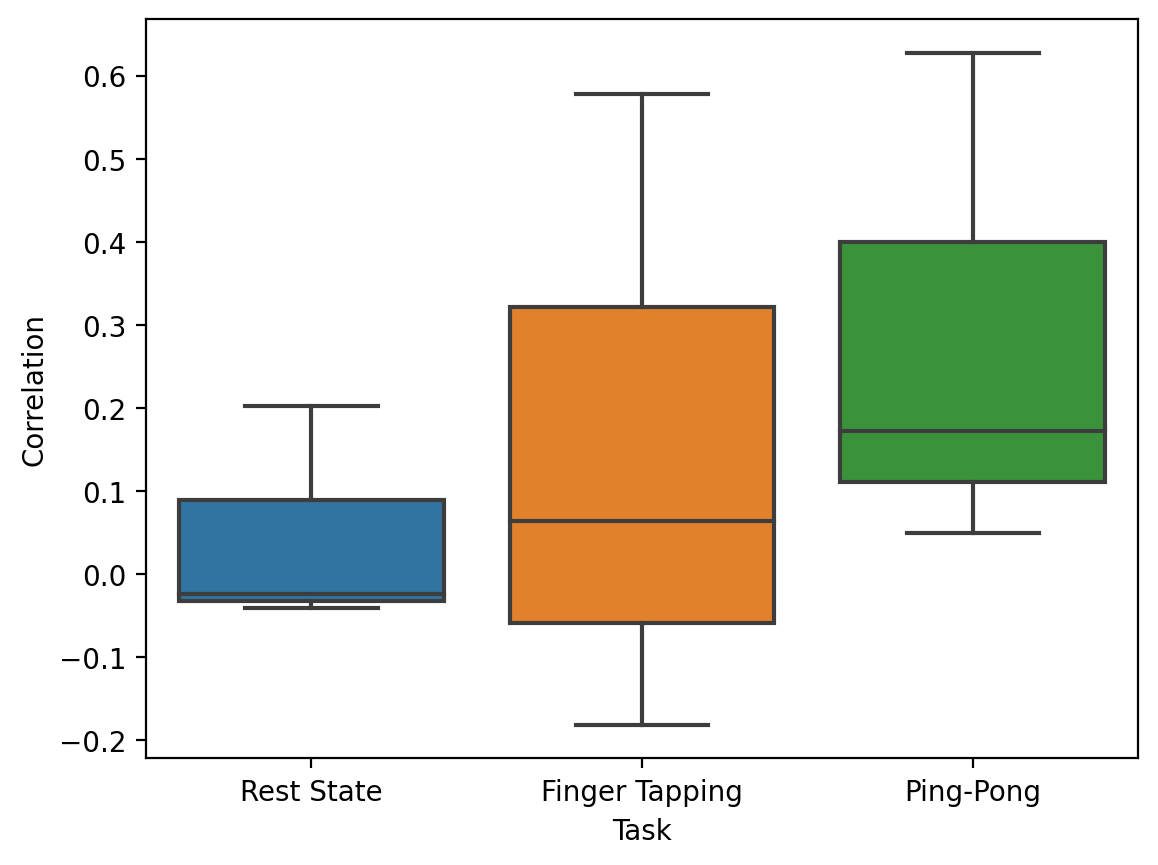

In [91]:
rest_state_corr = np.array(correlate_all(rest_state_df)[np.triu_indices(3, k=1)])
finger_tapping_corr = np.array(correlate_all(finger_tapping_df)[np.triu_indices(3, k=1)])
ping_pong_corr = np.array(correlate_all(ping_pong_df)[np.triu_indices(3, k=1)])
corr_df = pd.DataFrame({"Rest State": rest_state_corr, "Finger Tapping": finger_tapping_corr, "Ping-Pong": ping_pong_corr})

sns.boxplot(pd.melt(corr_df, id_vars=[], var_name='Task', value_name='Correlation'), x="Task", y="Correlation")

# RQ3. Is coordination similar in shape across teams in the same task with similar performance?

In [ ]:
finger_tapping

corr_and_performance_df = corr_df.copy()
corr_and_performance_df["Performance"] = 